In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt, seaborn as sns
sns.set()

In [2]:
# Connect Colab with Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load data
df = pd.read_csv("/content/drive/MyDrive/DATA 6560/Data/Final dataset/merged_data (1).csv")

# Drop outliers identified in CP5 + Countries where the NFL already has games
df = df[~df["Country"].isin(["Papua New Guinea", "United States", "United Kingdom", "Germany", "Spain", "Brazil", "Ireland"])].copy()

# Find rows with any missing values
rows_with_na = df[df.isna().any(axis=1)]

# Define column names explicitly
fan_col = "gt_composite"
stadium_count_col = "stadium_count"
stadium_capacity_col = "average_stadium_capacity"
gdp_col = "gdp_per_capita"
population_col = "population"
urban_col = "urban_pct"
connect_col = "connectivity_index"
country_col = "Country"

# Show unique country names
countries_with_na = rows_with_na[country_col].unique()

print("Countries with missing values:")
print(list(countries_with_na))

# Drop rows with missing values
df = df.dropna().copy()

print("Remaining rows after dropping missing values:", len(df))

df.isna().sum().sum()

Countries with missing values:
['American Samoa', 'Andorra', 'Aruba', 'Belize', 'Bermuda', 'Bhutan', 'British Virgin Islands', 'Cayman Islands', 'Comoros', 'Dominica', 'Eritrea', 'Eswatini', 'Faroe Islands', 'French Polynesia', 'Gibraltar', 'Greenland', 'Grenada', 'Guam', 'Guyana', 'Haiti', 'Iceland', 'Isle of Man', 'Kiribati', 'Kosovo', 'Latvia', 'Lebanon', 'Liechtenstein', 'Luxembourg', 'Marshall Islands', 'Mongolia', 'Namibia', 'Nauru', 'New Caledonia', 'Northern Mariana Islands', 'Palau', 'Samoa', 'San Marino', 'Sierra Leone', 'Solomon Islands', 'South Sudan', 'St. Lucia', 'Suriname', 'Switzerland', 'Timor-Leste', 'Tonga', 'Tuvalu', 'Vanuatu']
Remaining rows after dropping missing values: 128


np.int64(0)

In [5]:
# Inspect columns
print(df.columns)

Index(['ISO2', 'Country', 'gt_NFL', 'gt_American_football', 'gt_Super_Bowl',
       'gt_composite', 'gdp_per_capita', 'population', 'urban_pct',
       'stadium_count', 'total_stadium_capacity', 'average_stadium_capacity',
       'airport_count', 'total_routes', 'unique_dest_countries',
       'hub_strength', 'airport_count_scaled', 'total_routes_scaled',
       'unique_dest_countries_scaled', 'hub_strength_scaled',
       'connectivity_index'],
      dtype='object')


In [6]:
# Normalize raw inputs to 0–1
scaler = MinMaxScaler()

cols_to_scale = [
    fan_col,
    stadium_count_col, stadium_capacity_col,
    gdp_col, population_col, urban_col, connect_col
]

df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# ----- Create composite pillars -----

# Infrastructure Readiness (simple average)
df["infrastructure_readiness"] = (
    df[stadium_count_col] * 0.5 +
    df[stadium_capacity_col] * 0.5
)

# Economic Readiness (weighted average)
df["economic_readiness"] = (
    df[gdp_col] * 0.5 +
    df[population_col] * 0.1 +
    df[urban_col] * 0.4
)

In [7]:
# MAI weights # 1
w_fan = 0.25
w_econ = 0.25
w_infra = 0.25
w_connect = 0.25

# Create composite index

df["MAI"] = (
    w_fan * df[fan_col] +
    w_econ * df["economic_readiness"] +
    w_infra * df["infrastructure_readiness"] +
    w_connect * df[connect_col]
)

# Rank markets
df["MAI_rank"] = df["MAI"].rank(ascending=False)

# Top 10
top10 = df.sort_values("MAI", ascending=False)[[country_col, "MAI"]].head(10)
print(top10)


                  Country       MAI
30                 Canada  0.595540
35                  China  0.517537
58                 France  0.435222
109                Mexico  0.420938
9               Australia  0.400370
119           Netherlands  0.371630
138                 Qatar  0.363405
173  United Arab Emirates  0.339985
10                Austria  0.339761
149             Singapore  0.333719


In [10]:
# Stability Test

n_sim = 300
top_k = 10

appearance = dict.fromkeys(df[country_col], 0)

for _ in range(n_sim):
    # 4 random weights that sum to 1
    w_fan, w_econ, w_infra, w_connect = np.random.dirichlet([1,1,1,1])

    mai_temp = (
        w_fan * df[fan_col] +
        w_econ * df["economic_readiness"] +
        w_infra * df["infrastructure_readiness"] +
        w_connect * df[connect_col]
    )

    tmp = df.assign(MAI_tmp=mai_temp)

    top = tmp.sort_values("MAI_tmp", ascending=False).head(top_k)[country_col]

    for c in top:
        appearance[c] += 1

stability = (
    pd.DataFrame({
        country_col: list(appearance.keys()),
        "top10_appearance_rate": [v / n_sim for v in appearance.values()]
    })
    .sort_values("top10_appearance_rate", ascending=False)
)

print(stability.head(10))

                  Country  top10_appearance_rate
22                 Canada               0.973333
26                  China               0.933333
6               Australia               0.906667
44                 France               0.870000
84            Netherlands               0.770000
99                  Qatar               0.720000
77                 Mexico               0.626667
7                 Austria               0.496667
122  United Arab Emirates               0.403333
107             Singapore               0.380000


In [11]:
# Clustering
cluster_cols = [
    fan_col,
    "economic_readiness",
    "infrastructure_readiness",
    connect_col
]


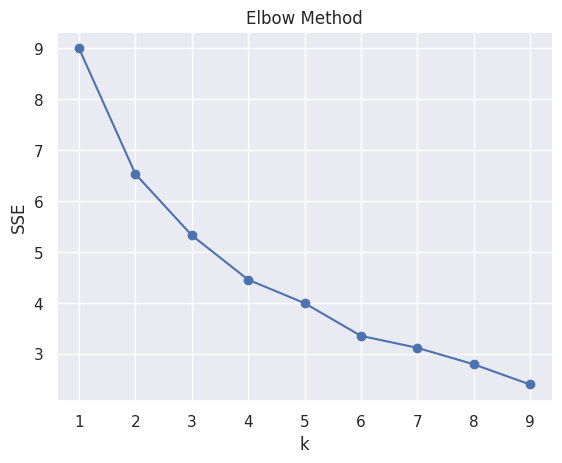

In [12]:
# Elbow method
sse = [KMeans(n_clusters=k, random_state=42).fit(df[cluster_cols]).inertia_ for k in range(1,10)]
plt.plot(range(1,10), sse, 'o-'); plt.xlabel('k'); plt.ylabel('SSE'); plt.title('Elbow Method'); plt.show()

In [13]:
# K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42).fit(df[cluster_cols])
labels = kmeans.labels_

kmeans

KMeans(n_clusters=4, random_state=42)

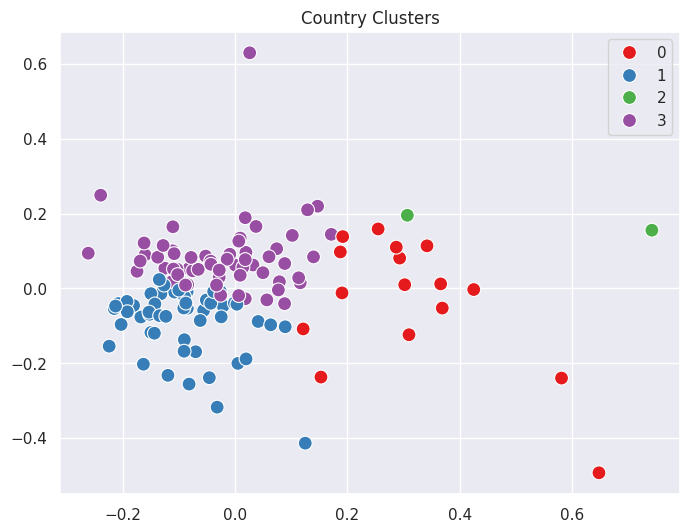

In [14]:
# PCA
pca = PCA(n_components=2)
comp = pca.fit_transform(df[cluster_cols])
plt.figure(figsize=(8,6))
sns.scatterplot(x=comp[:,0], y=comp[:,1], hue=labels, palette='Set1', s=100)
plt.title('Country Clusters'); plt.show()

In [15]:
# Add cluster labels to dataframe
df["cluster"] = labels

# Show country + assigned cluster
cluster_map = df[[country_col, "cluster"]].sort_values("cluster")

cluster_map

df.groupby("cluster")[country_col].apply(list)

cluster_map.to_csv("/content/drive/MyDrive/DATA 6560/Data/Final dataset/country_clusters.csv", index=False)

In [16]:
print(cluster_map.to_string(index=False))

                 Country  cluster
               Australia        0
                 Austria        0
                 Belgium        0
                   China        0
                   India        0
                   Japan        0
                  France        0
                 Denmark        0
                   Italy        0
                  Israel        0
                   Qatar        0
                  Sweden        0
    United Arab Emirates        0
               Singapore        0
            South Africa        0
             Netherlands        0
                   Egypt        1
                Ethiopia        1
                 Georgia        1
                   Ghana        1
                   Kenya        1
           Guinea-Bissau        1
               Indonesia        1
                  Guinea        1
                 Burundi        1
             El Salvador        1
            Burkina Faso        1
                    Chad        1
              